In [1]:
import os
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as implt
from PIL import Image 
import keras, cv2, shutil, keras_preprocessing, requests, math, glob, datetime
import tensorflow as tf
from keras import layers
from keras.models import Sequential, Model 
from keras.layers import Lambda, Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation, SpatialDropout2D, GlobalAveragePooling2D 
from keras.callbacks import EarlyStopping
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from keras.applications.xception import Xception, preprocess_input as xception_preprocessor
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input as inc_resnet_preprocessor
from keras.applications.nasnet import NASNetLarge, preprocess_input as nasnet_preprocessor
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.datasets import load_files
from io import BytesIO
import seaborn as sns
import xml.etree.ElementTree as ET
from tensorflow.keras.utils import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from pathlib import Path
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
%load_ext tensorboard
shutil.rmtree('./logs', ignore_errors=True)

In [2]:
train_dir = "C:/Users/kjosh/OneDrive/Documents/UChicago/ADSP 31009 - Machine Learning & Predictive Analytics/Final Project/Train_Test_Split/train/" 

In [3]:
test_dir = "C:/Users/kjosh/OneDrive/Documents/UChicago/ADSP 31009 - Machine Learning & Predictive Analytics/Final Project/Train_Test_Split/test/" 

In [4]:
target_size = (128, 128)
input_shape = (128, 128, 3)

In [5]:
batch_size = 256

In [6]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range = 0.3,
    zoom_range = 0.3,
    horizontal_flip=True,
    rotation_range = 30
)

In [7]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical')

Found 17651 images belonging to 120 classes.


In [8]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)

In [9]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 4475 images belonging to 120 classes.


In [10]:
inputs = keras.Input(shape=input_shape)

base_incept_model = keras.applications.InceptionV3(input_shape=input_shape, include_top=False)
base_incept_model.trainable = False

In [11]:
x = base_incept_model.output
x = GlobalAveragePooling2D()(x)
outputs = Dense(120, activation='softmax')(x)
model = keras.Model(base_incept_model.input, outputs)
for layer in base_incept_model.layers: layer.trainable = False

In [13]:
optimizer = keras.optimizers.Adam(learning_rate=0.01, epsilon=0.1)

In [14]:
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [15]:
early_stoppage_callback = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.001, patience=7, restore_best_weights = True)

In [16]:
history = model.fit(train_generator, 
            steps_per_epoch = 20,
            epochs=50,
            verbose=1,
            validation_data=test_generator, 
            callbacks=[early_stoppage_callback]
            )

Epoch 1/50
20/20 [==============================] - 220s 11s/step - loss: 7.0796 - accuracy: 0.0211 - val_loss: 5.1705 - val_accuracy: 0.0713
Epoch 2/50
20/20 [==============================] - 216s 11s/step - loss: 4.1802 - accuracy: 0.1641 - val_loss: 2.8816 - val_accuracy: 0.3350
Epoch 3/50
20/20 [==============================] - 243s 12s/step - loss: 3.0882 - accuracy: 0.3213 - val_loss: 2.1863 - val_accuracy: 0.4619
Epoch 4/50
20/20 [==============================] - 208s 11s/step - loss: 2.5523 - accuracy: 0.3980 - val_loss: 1.9861 - val_accuracy: 0.5039
Epoch 5/50
20/20 [==============================] - 200s 10s/step - loss: 2.4003 - accuracy: 0.4279 - val_loss: 1.8498 - val_accuracy: 0.5303
Epoch 6/50
20/20 [==============================] - 117s 6s/step - loss: 2.2752 - accuracy: 0.4568 - val_loss: 1.8104 - val_accuracy: 0.5497
Epoch 7/50
20/20 [==============================] - 103s 5s/step - loss: 2.1824 - accuracy: 0.4746 - val_loss: 1.8006 - val_accuracy: 0.5522
Epoch 8/

In [17]:
history_df = pd.DataFrame(history.history)

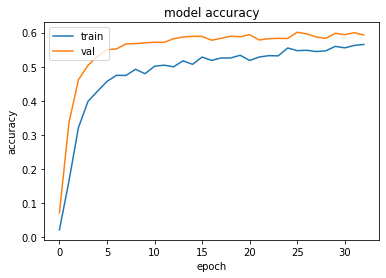

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

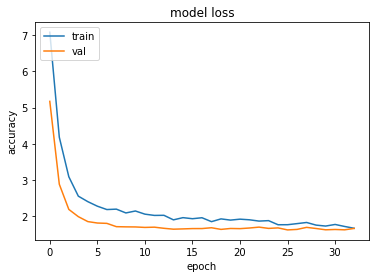

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [20]:
class_labels = []
for i in os.listdir('C:/Users/kjosh/OneDrive/Documents/UChicago/ADSP 31009 - Machine Learning & Predictive Analytics/Final Project/Train_Test_Split/train/'):
    class_labels.append(i)

In [21]:
predictions = []
confidence = []

In [22]:
example_images = "C:/Users/kjosh/OneDrive/Documents/UChicago/ADSP 31009 - Machine Learning & Predictive Analytics/Final Project/Test_Images/"

In [23]:
for image in os.listdir(example_images): 
    my_image = load_img(os.path.join(example_images,image), target_size=target_size)
    my_image = img_to_array(my_image)
    my_image = my_image/255
    my_image = my_image.reshape((1, my_image.shape[0], my_image.shape[1], my_image.shape[2]))
    prediction = model.predict(my_image)
    predicted_class_index = np.argmax(prediction)
    predictions.append(class_labels[predicted_class_index])
    confidence.append(round(prediction[0][predicted_class_index] * 100, 2))

1/1 [==============================] - 0s 116ms/step


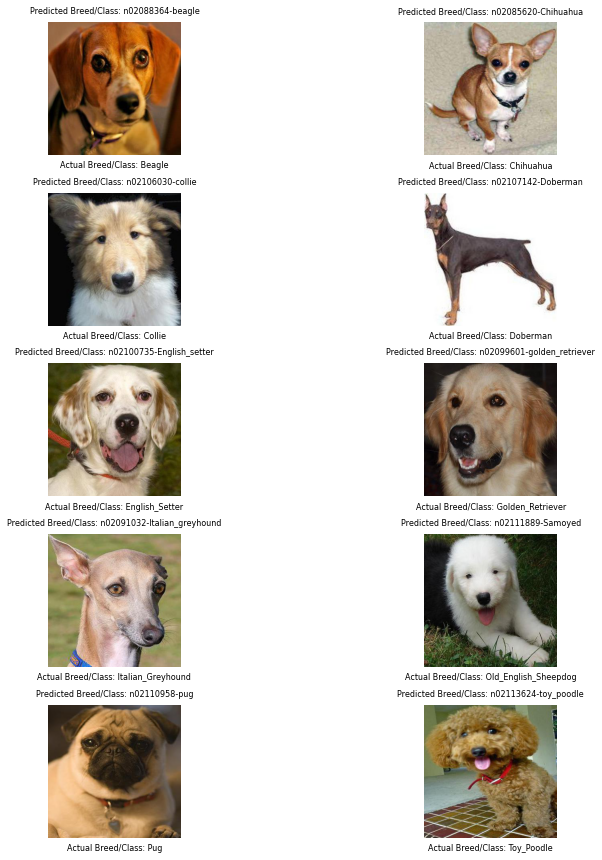

In [24]:
# Get a list of all image files in the directory
image_files = [file for file in os.listdir(example_images)]

# Set up the plot with multiple subplots
num_images = len(image_files)
num_cols = 2  # Number of columns in the plot
num_rows = (num_images - 1) // num_cols + 1  # Number of rows in the plot

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

# Loop through the image files and plot them
for i, file in enumerate(image_files):
    row = i // num_cols
    col = i % num_cols

    # Load the image using matplotlib's imread function
    image_path = os.path.join(example_images, file)
    image = plt.imread(image_path)

    # Plot the image on the corresponding subplot
    axes[row, col].imshow(image)
    axes[row, col].axis('off')
    axes[row, col].text(0.5, -0.1, f'Actual Breed/Class: {os.path.splitext(file)[0]}', fontsize=8, ha='center', transform=axes[row, col].transAxes)
    axes[row, col].text(0.5, 1.06, f'Predicted Breed/Class: {predictions[i]}', fontsize=8, ha='center', transform=axes[row, col].transAxes)
# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()